In [41]:
import numpy as np
import pandas as pd

# 1) Read data

In [42]:
file_path = r"D:\Duy\duyRepository\pandas-exercise-v1\data\raw\customers.csv"
data = pd.read_csv(file_path)

# 2) Inspect data (always)

In [43]:
print(data.shape)
print(data.head())
print(data.isna().sum())

(6, 6)
   customer_id   age   income country  price  bought
0            1  25.0  40000.0     USA    100       0
1            2  45.0  80000.0     USA    200       1
2            3  35.0  60000.0  France    150       1
3            4   NaN  52000.0  France    120       0
4            5  50.0      NaN     NaN    300       1
customer_id    0
age            1
income         1
country        1
price          0
bought         0
dtype: int64


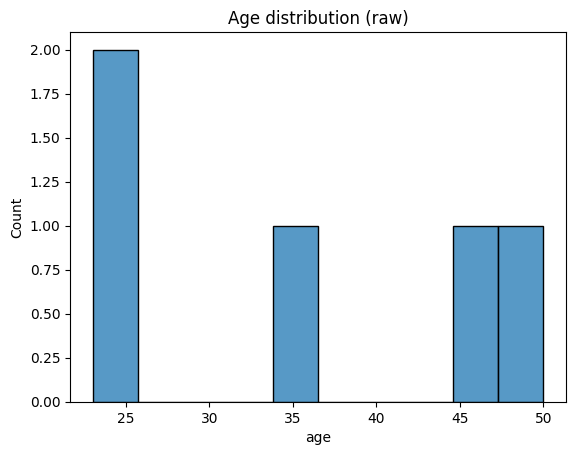

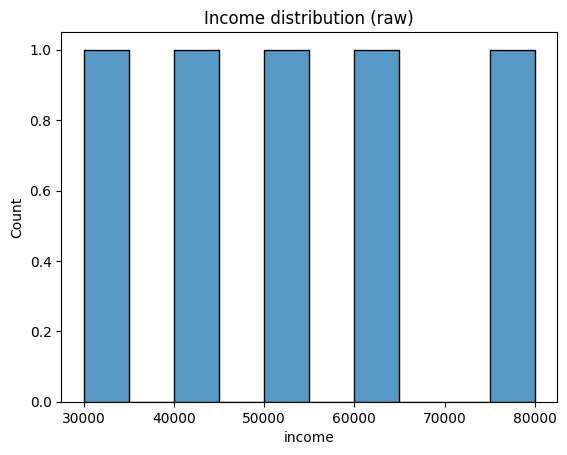

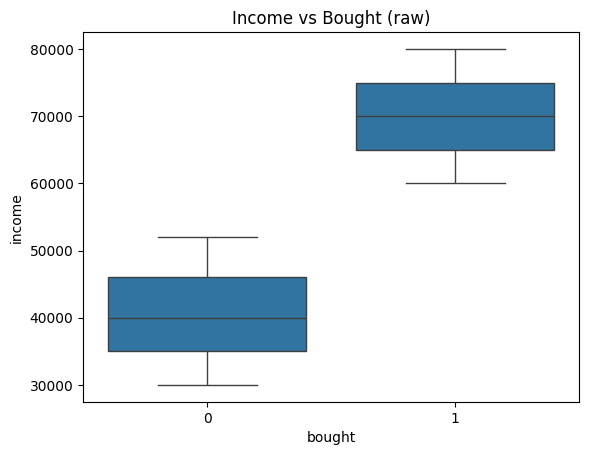

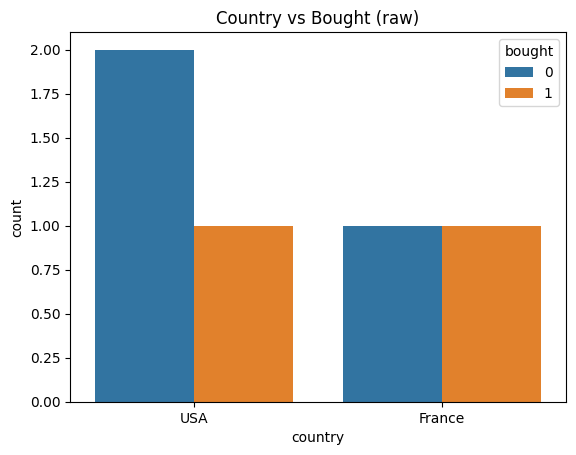

In [44]:
# 2.5) EDA plots (BEFORE cleaning)
# Plots (EDA + evaluation)
import matplotlib.pyplot as plt
import seaborn as sns

# Goal: see distributions + relationship to target
plt.figure()
sns.histplot(data["age"], bins=10)
plt.title("Age distribution (raw)")
plt.show()

plt.figure()
sns.histplot(data["income"], bins=10)
plt.title("Income distribution (raw)")
plt.show()

plt.figure()
sns.boxplot(x="bought", y="income", data=data)
plt.title("Income vs Bought (raw)")
plt.show()

plt.figure()
sns.countplot(x="country", hue="bought", data=data)
plt.title("Country vs Bought (raw)")
plt.show()

# 3) Separate target and features

In [45]:
target_col = "bought"
y = data[target_col]
X = data.drop(columns=[target_col])

# 4) Create train/validation split (because no test file)

In [46]:
np.random.seed(42)
idx = np.arange(len(X))
np.random.shuffle(idx)

In [47]:
split = int(0.8 * len(idx))
train_idx = idx[:split]
valid_idx = idx[split:]

In [48]:
X_train = X.iloc[train_idx].reset_index(drop=True)
y_train = y.iloc[train_idx].reset_index(drop=True)

In [49]:
X_valid = X.iloc[valid_idx].reset_index(drop=True)
y_valid = y.iloc[valid_idx].reset_index(drop=True)

# 5) Combine for consistent cleaning

In [50]:
all_data = pd.concat([X_train, X_valid], axis=0, ignore_index=True)

# 6) Handle missing values

In [51]:
num_cols = all_data.select_dtypes(include=["number"]).columns
cat_cols = all_data.select_dtypes(exclude=["number"]).columns
print(num_cols)
print(cat_cols)

Index(['customer_id', 'age', 'income', 'price'], dtype='object')
Index(['country'], dtype='object')


In [52]:
for col in num_cols:
    all_data[col] = all_data[col].fillna(all_data[col].median())

print(all_data[col].isna().sum())

0


In [53]:
for col in cat_cols:
    all_data[col] = all_data[col].fillna("Unknown")
    
print(all_data[col].isna().sum())

0


# 7) Feature engineering

In [54]:
all_data["income_log1p"] = np.log1p(all_data["income"])
all_data["income_per_age"] = all_data["income"] / np.maximum(all_data["age"], 1)

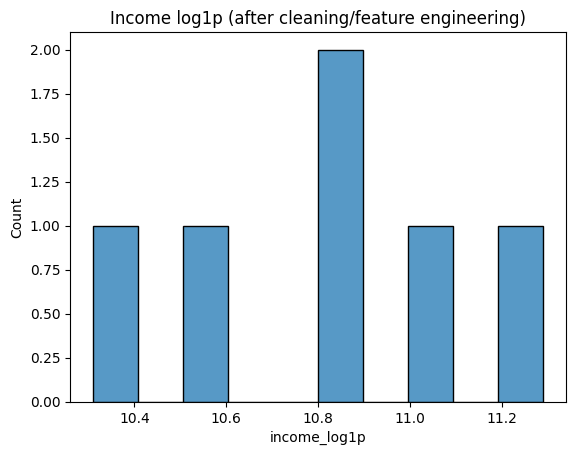

In [55]:
# 7.5) EDA after feature engineering (optional sanity check)
# -------------------------
plt.figure()
sns.histplot(all_data["income_log1p"], bins=10)
plt.title("Income log1p (after cleaning/feature engineering)")
plt.show()

# 8) Encode categoricals

In [56]:
all_encoded = pd.get_dummies(all_data, columns=cat_cols, drop_first=False)
all_encoded.head()

,customer_id,age,income,price,income_log1p,income_per_age,country_France,country_USA,country_Unknown
0,1,25.0,40000.0,100,10.596660,1600.000000,False,True,False
1,2,45.0,80000.0,200,11.289794,1777.777778,False,True,False
2,6,23.0,30000.0,80,10.308986,1304.347826,False,True,False
3,3,35.0,60000.0,150,11.002117,1714.285714,True,False,False
4,5,50.0,52000.0,300,10.859018,1040.000000,False,False,True


# 9) Split back into train/valid

In [57]:
X_train_clean = all_encoded.iloc[:len(X_train), :].copy()
X_valid_clean = all_encoded.iloc[len(X_train):, :].copy()

# 10) Save cleaned outputs

In [58]:
from pathlib import Path

output_dir = Path(r"D:\Duy\duyRepository\pandas-exercise-v1\data\processed")
output_dir.mkdir(parents=True, exist_ok=True)

In [59]:
X_train_clean.to_csv(output_dir / "X_train_clean.csv", index=False)
y_train.to_csv(output_dir / "y_train.csv", index=False)

In [60]:
X_valid_clean.to_csv(output_dir / "X_valid_clean.csv", index=False)
y_valid.to_csv(output_dir / "y_valid.csv", index=False)

# 11) Train your first model (Logistic Regression)

In [61]:
# ML
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

In [62]:
# 11.1 Create the model
model = LogisticRegression(max_iter=1000)

In [63]:
# 11.2 Fit (train)
model.fit(X_train_clean, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [64]:
# 11.3 Predict on validation set
y_pred = model.predict(X_valid_clean)

In [65]:
# 11.4 Accuracy
accuracy = accuracy_score(y_valid, y_pred)
print("\nValidation accuracy:", accuracy)


Validation accuracy: 0.5


In [66]:
# 11.5 Compare actual vs predicted
comparison = pd.DataFrame({
    "Actual": y_valid.values,
    "Predicted": y_pred
})
print("\nActual vs Predicted:\n", comparison)


Actual vs Predicted:
    Actual  Predicted
0       1          1
1       0          1


In [67]:
# 11.6 Prediction probabilities
y_proba = model.predict_proba(X_valid_clean)
proba_df = pd.DataFrame(y_proba, columns=["P(bought=0)", "P(bought=1)"])
print("\nPrediction probabilities:\n", proba_df)


Prediction probabilities:
     P(bought=0)  P(bought=1)
0  2.397194e-11     1.000000
1  1.857106e-04     0.999814


# 12) Model evaluation plots (AFTER training)

In [68]:
# Confusion matrix
cm = confusion_matrix(y_valid, y_pred)

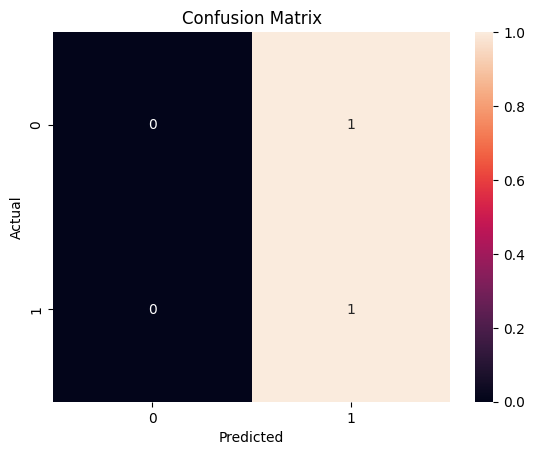

In [71]:
plt.figure()
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# The model predicts only “bought”, catching buyers but failing to identify non-buyers.

In [72]:
# Optional: Logistic Regression "feature importance" (coefficients)
# Positive coefficient -> pushes prediction towards bought=1
coef = pd.Series(model.coef_[0], index=X_train_clean.columns).sort_values()

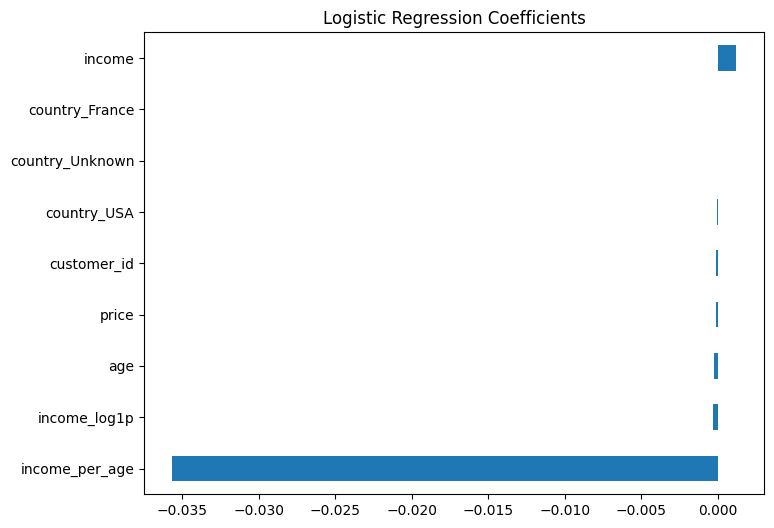

In [74]:
plt.figure(figsize=(8, 6))
coef.plot(kind="barh")
plt.title("Logistic Regression Coefficients")
plt.show()

# Logistic Regression coefficients tell you which features push predictions toward yes or no, and how strongly.

# 11.1) Model hygiene: drop ID column

In [76]:
X_train_hygiene = X_train_clean.drop(columns=["customer_id"])
X_valid_hygiene = X_valid_clean.drop(columns=["customer_id"])

print("Before:", X_train_clean.shape)
print("After:", X_train_hygiene.shape)

Before: (4, 9)
After: (4, 8)


# 12.1) Retrain Logistic Regression (clean version)

In [77]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model = LogisticRegression(max_iter=1000)
model.fit(X_train_hygiene, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


# 13) Predict again

In [78]:
y_pred = model.predict(X_valid_hygiene)

# 14) Evaluate again (accuracy)

In [79]:
accuracy = accuracy_score(y_valid, y_pred)
print("Validation accuracy (after dropping ID):", accuracy)

Validation accuracy (after dropping ID): 0.5


# 15) Inspect predictions vs truth

In [80]:
pd.DataFrame({
    "Actual": y_valid.values,
    "Predicted": y_pred
})


,Actual,Predicted
0,1,1
1,0,1


# 16) Re-check coefficients (KEY LEARNING)

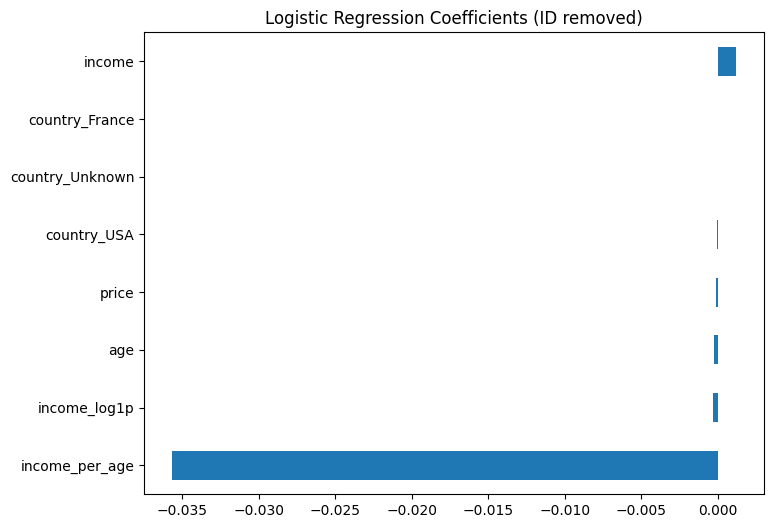

In [81]:
import matplotlib.pyplot as plt

coef = pd.Series(
    model.coef_[0],
    index=X_train_hygiene.columns
).sort_values()

plt.figure(figsize=(8, 6))
coef.plot(kind="barh")
plt.title("Logistic Regression Coefficients (ID removed)")
plt.show()

# Decision Tree model (train + predict)

In [82]:
from sklearn.tree import DecisionTreeClassifier

# Create a Decision Tree model
tree_model = DecisionTreeClassifier(
    random_state=42,     # makes results repeatable
    max_depth=3          # limit depth so it doesn't "memorize" tiny data too hard
)

# Train (fit)
tree_model.fit(X_train_hygiene, y_train)

# Predict on validation
tree_pred = tree_model.predict(X_valid_hygiene)

tree_pred

array([1, 1])

Evaluate Decision Tree (accuracy + view predictions)

In [83]:
from sklearn.metrics import accuracy_score
import pandas as pd

tree_acc = accuracy_score(y_valid, tree_pred)
print("Decision Tree validation accuracy:", tree_acc)

pd.DataFrame({
    "Actual": y_valid.values,
    "Tree_Predicted": tree_pred
})


Decision Tree validation accuracy: 0.5


,Actual,Tree_Predicted
0,1,1
1,0,1


Compare Logistic Regression vs Decision Tree (side-by-side)

In [84]:
from sklearn.linear_model import LogisticRegression

# Re-train Logistic Regression (clean features)
logreg_model = LogisticRegression(max_iter=1000)
logreg_model.fit(X_train_hygiene, y_train)

logreg_pred = logreg_model.predict(X_valid_hygiene)
logreg_acc = accuracy_score(y_valid, logreg_pred)

print("Logistic Regression validation accuracy:", logreg_acc)
print("Decision Tree validation accuracy:", tree_acc)

comparison = pd.DataFrame({
    "Actual": y_valid.values,
    "LogReg_Predicted": logreg_pred,
    "Tree_Predicted": tree_pred
})

comparison


Logistic Regression validation accuracy: 0.5
Decision Tree validation accuracy: 0.5


,Actual,LogReg_Predicted,Tree_Predicted
0,1,1,1
1,0,1,1


Confusion matrices (visual + super useful)

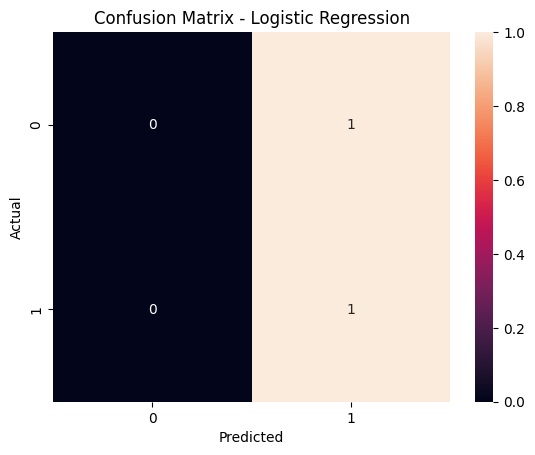

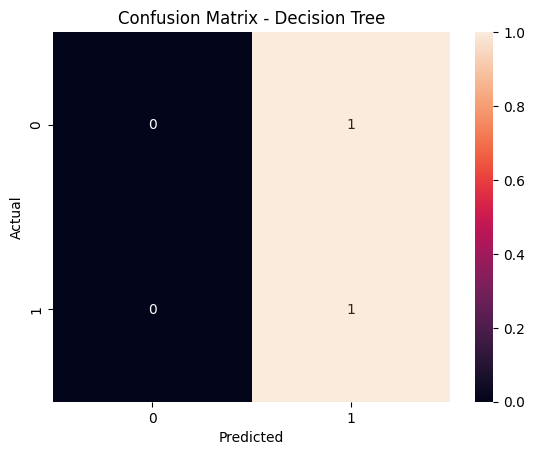

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Logistic Regression confusion matrix
cm_logreg = confusion_matrix(y_valid, logreg_pred)

plt.figure()
sns.heatmap(cm_logreg, annot=True, fmt="d")
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Decision Tree confusion matrix
cm_tree = confusion_matrix(y_valid, tree_pred)

plt.figure()
sns.heatmap(cm_tree, annot=True, fmt="d")
plt.title("Confusion Matrix - Decision Tree")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


OPTIONAL (but awesome): see the Decision Tree rules

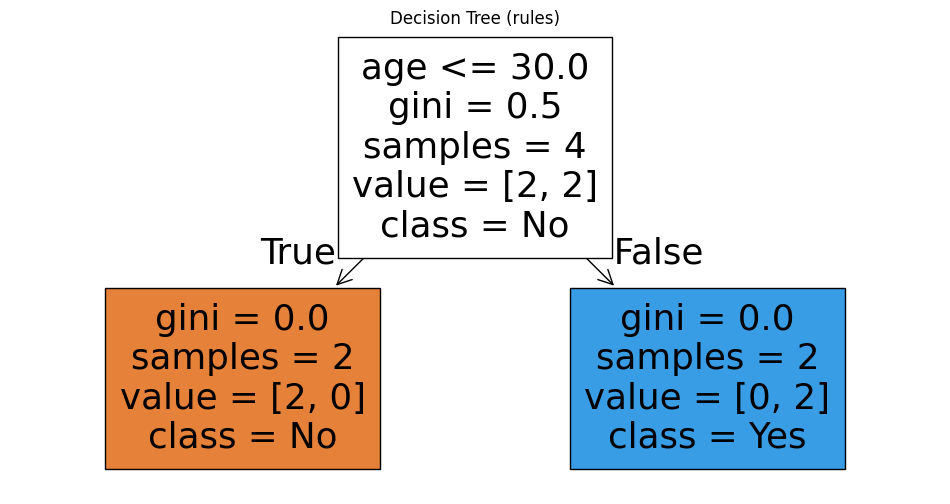

In [86]:
from sklearn.tree import plot_tree

plt.figure(figsize=(12, 6))
plot_tree(
    tree_model,
    feature_names=X_train_hygiene.columns,
    class_names=["No", "Yes"],
    filled=True
)
plt.title("Decision Tree (rules)")
plt.show()


# What cross-validation is (simple)

Instead of splitting once:
- Split the data into K parts (folds)
- Train on K-1 parts
- Validate on the remaining part
- Repeat K times
- Average the scores

## Analogy:
Instead of giving a student one test, you give them 5 small tests and average the grade.

Prepare the clean feature matrix for CV

We’ll run CV on the clean + encoded features, without customer_id.

In [87]:
# We'll use the same clean features we trained with
X_cv = X_train_hygiene.copy()
y_cv = y_train.copy()

print("X_cv shape:", X_cv.shape)
print("y_cv shape:", y_cv.shape)

X_cv shape: (4, 8)
y_cv shape: (4,)


Cross-validation for Logistic Regression

In [89]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
import numpy as np

logreg = LogisticRegression(max_iter=1000)

cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

logreg_scores = cross_val_score(logreg, X_cv, y_cv, cv=cv, scoring="accuracy")

print("LogReg CV scores:", logreg_scores)
print("LogReg CV mean:", np.mean(logreg_scores))
print("LogReg CV std:", np.std(logreg_scores))


LogReg CV scores: [1.  0.5]
LogReg CV mean: 0.75
LogReg CV std: 0.25


Cross-validation for Decision Tree

In [90]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=42, max_depth=3)

tree_scores = cross_val_score(tree, X_cv, y_cv, cv=cv, scoring="accuracy")

print("Tree CV scores:", tree_scores)
print("Tree CV mean:", np.mean(tree_scores))
print("Tree CV std:", np.std(tree_scores))


Tree CV scores: [1. 1.]
Tree CV mean: 1.0
Tree CV std: 0.0


Compare models (nice summary table)

In [91]:
results = pd.DataFrame({
    "Model": ["Logistic Regression", "Decision Tree"],
    "CV Mean Accuracy": [np.mean(logreg_scores), np.mean(tree_scores)],
    "CV Std": [np.std(logreg_scores), np.std(tree_scores)]
})

results


,Model,CV Mean Accuracy,CV Std
0,Logistic Regression,0.75,0.25
1,Decision Tree,1.00,0.00


# Decision Tree Tuning (Kaggle-style)
What we tune (simple meanings)
- max_depth: how many “questions” the tree can ask
- too big → memorizes (overfit)
- too small → too simple (underfit)
- min_samples_leaf: minimum rows allowed in a leaf
- bigger → smoother, less overfit
- smaller → more flexible

Grid search with cross-validation

In [95]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier

cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

tree = DecisionTreeClassifier(random_state=42)

param_grid = {
    "max_depth": [1, 2, 3, None],
    "min_samples_leaf": [1, 2]
}

grid = GridSearchCV(
    estimator=tree,
    param_grid=param_grid,
    scoring="accuracy",
    cv=cv
)

grid.fit(X_cv, y_cv)

print("Best CV accuracy:", grid.best_score_)
print("Best params:", grid.best_params_)

Best CV accuracy: 1.0
Best params: {'max_depth': 1, 'min_samples_leaf': 1}


View all results (like Kaggle experiments)

In [96]:
results = pd.DataFrame(grid.cv_results_)

# Keep only useful columns
results = results[[
    "mean_test_score",
    "std_test_score",
    "param_max_depth",
    "param_min_samples_leaf"
]].sort_values(by="mean_test_score", ascending=False)

results


,mean_test_score,std_test_score,param_max_depth,param_min_samples_leaf
0,1.0,0.0,1,1
2,1.0,0.0,2,1
6,1.0,0.0,None,1
4,1.0,0.0,3,1
3,0.5,0.0,2,2
1,0.5,0.0,1,2
5,0.5,0.0,3,2
7,0.5,0.0,None,2


Train the “best tree” and evaluate on your validation set

In [97]:
best_tree = grid.best_estimator_

# Fit on training data (clean features)
best_tree.fit(X_train_hygiene, y_train)

# Predict on validation
best_tree_pred = best_tree.predict(X_valid_hygiene)

from sklearn.metrics import accuracy_score
best_tree_acc = accuracy_score(y_valid, best_tree_pred)

print("Validation accuracy (best tuned tree):", best_tree_acc)

pd.DataFrame({
    "Actual": y_valid.values,
    "Predicted": best_tree_pred
})


Validation accuracy (best tuned tree): 0.5


,Actual,Predicted
0,1,1
1,0,1


Optional: Plot the tuned tree

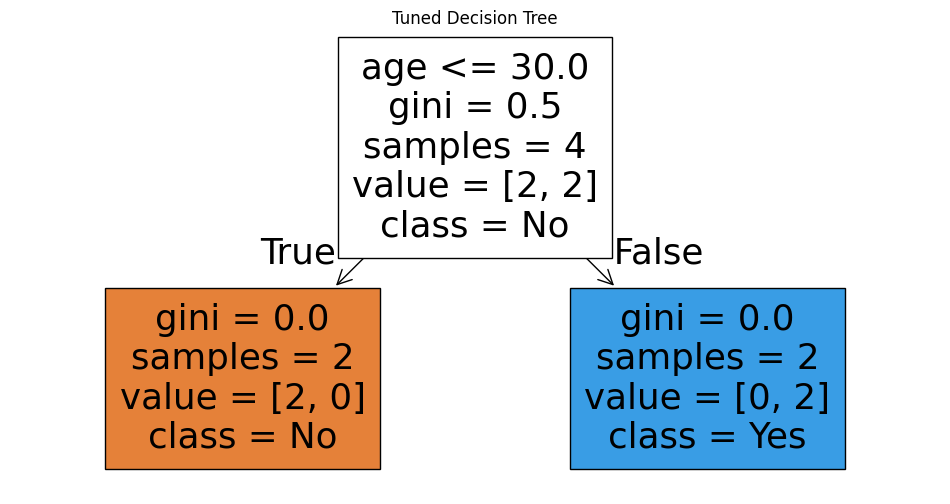

In [98]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(12, 6))
plot_tree(
    best_tree,
    feature_names=X_train_hygiene.columns,
    class_names=["No", "Yes"],
    filled=True
)
plt.title("Tuned Decision Tree")
plt.show()


# After tuning, you usually have multiple models:
- Logistic Regression
- Decision Tree
- Tuned Decision Tree
# Now you must:
- Select the best model
- Save it to disk
- Reload & reuse it later (or deploy it)

In [99]:
# -------------------------
# SELECT best model manually
# -------------------------

# Example: choose tuned Decision Tree
final_model = best_tree

print("Final model selected:", type(final_model).__name__)

Final model selected: DecisionTreeClassifier


Save the model (MOST IMPORTANT FOR DEPLOYMENT)
- We use joblib (industry standard for sklearn models).

In [102]:
import joblib

from pathlib import Path

output_models = Path(r"D:\Duy\duyRepository\pandas-exercise-v1\models")
output_models.mkdir(parents=True, exist_ok=True)

# Save model
joblib.dump(final_model, output_models / "final_model.joblib")

print(f"Model saved to {output_models / 'final_model.joblib'}")

Model saved to D:\Duy\duyRepository\pandas-exercise-v1\models\final_model.joblib


Save feature list (CRITICAL, often forgotten ❗)
- Models require the same feature order at inference time.

In [103]:
# Save feature names used during training
feature_columns = X_train_hygiene.columns.tolist()

joblib.dump(feature_columns, output_models / "feature_columns.joblib")

print(f"Feature columns saved to {output_models / 'feature_columns.joblib'}")

Feature columns saved to D:\Duy\duyRepository\pandas-exercise-v1\models\feature_columns.joblib


Reload model & features (reuse anywhere). This simulates:
- New notebook
- New script
- Production server
- API endpoint

In [105]:
# -------------------------
# REUSE / LOAD MODEL
# -------------------------
loaded_model = joblib.load(output_models / "final_model.joblib")
loaded_features = joblib.load(output_models / "feature_columns.joblib")

print(f"Loaded model: {type(loaded_model).__name__}")
print(f"Loaded features: {loaded_features}")

Loaded model: DecisionTreeClassifier
Loaded features: ['age', 'income', 'price', 'income_log1p', 'income_per_age', 'country_France', 'country_USA', 'country_Unknown']


Use model on NEW data (DEPLOYMENT SIMULATION)

In [106]:
# New unseen customer (RAW input)
new_customer = pd.DataFrame({
    "customer_id": [999],
    "age": [40],
    "income": [70000],
    "country": ["USA"],
    "price": [150]
})


# IMPORTANT: Apply SAME preprocessing
We must:
- drop ID
- create engineered features
- encode categories
- align columns

In [107]:
# Drop ID
new_customer = new_customer.drop(columns=["customer_id"])

# Feature engineering (same as training)
new_customer["income_log1p"] = np.log1p(new_customer["income"])
new_customer["income_per_age"] = new_customer["income"] / np.maximum(new_customer["age"], 1)

# One-hot encoding
new_encoded = pd.get_dummies(new_customer)

# Align columns with training features
new_encoded = new_encoded.reindex(columns=loaded_features, fill_value=0)

new_encoded


,age,income,price,income_log1p,income_per_age,country_France,country_USA,country_Unknown
0,40,70000,150,11.156265,1750.0,0,True,0


# Predict + probability (final output)

In [108]:
prediction = loaded_model.predict(new_encoded)
probability = loaded_model.predict_proba(new_encoded)

print("Prediction (0=No, 1=Yes):", prediction[0])
print("Probability bought=1:", probability[0][1])


Prediction (0=No, 1=Yes): 1
Probability bought=1: 1.0


# FastAPI inference service you can run locally
You should have:
- final_model.joblib
- feature_columns.joblib
### Put both in the same folder as app.py

In [110]:
import joblib

joblib.dump(final_model,   output_models / "final_model.joblib")
joblib.dump(X_train_hygiene.columns.tolist(), output_models / "feature_columns.joblib")

['D:\\Duy\\duyRepository\\pandas-exercise-v1\\models\\feature_columns.joblib']